# YOLOv8用于检测牌的位置，而LSTM则学习这些位置的时间序列模式，从而预测未来的行为。
- You Only Look Once YOLO 接受整张图片作为输入划分为网格，每个网格预测一组边界框和对应的物体类别，这让 YOLO 很快
- YOLO 将物体检测视为回归问题来解决，直接从图片生成边界框坐标和类别概率
- LSTM Long Short-Term Memory 长短期记忆网络，适合时间序列预测的行为模式

**这是一个相对复杂的深度学习应用，适用于人和动物行为研究中需要分析大量序列数据的场景。**

## 数据预处理
样本数num_samples: 54 poker, 每个样本time_steps: 20个时间序列, 每个时间序列num_features: 10个特征(待加入更多)

In [1]:
%pip install keras filterpy opencv-python numpy scikit-learn pandas tf2onnx onnx onnxruntime onnx-coreml

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install the ultralytics package from GitHub
%pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /private/var/folders/39/wllj512d2dv845j_wdx3vctc0000gn/T/pip-req-build-0qi14jqu
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /private/var/folders/39/wllj512d2dv845j_wdx3vctc0000gn/T/pip-req-build-0qi14jqu
  Resolved https://github.com/ultralytics/ultralytics.git to commit 1a497f174c21993e2464725d96482e2a4a52758b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.2.86-py3-none-any.whl size=872031 sha256=1e72beb6b6206e75f9557d401bad09ea5ebb325406b22618f5075748b037cb0b
  Stored in directory: /private/var/folders/39/wllj512d2dv845j_wdx3vctc0000gn/T/pip-ephem-wheel-cache-8fgp62ji/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics
  Attempting uninstall: ultralytics
    Foun

## 1. YOLOv8 模型检测

In [32]:

from ultralytics import YOLO
import torch
import cv2
import numpy as np

#from sort import Sort
#https://github.com/RizwanMunawar/yolov7-object-tracking/blob/main/sort.py

from keras.models import load_model, Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, Masking, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.saving import serialize_keras_object

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os

from concurrent.futures import ThreadPoolExecutor, as_completed
import logging

logging.basicConfig(filename='poker_analysis.log', level=logging.INFO, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

# 加载YOLOv8 模型
#yolo_model = YOLO('poker/n_pretrain/weights/best.pt')
yolo_model = YOLO("poker/n_pretrain/weights/pokerDetect_0821-fp-16-int8-not-nms.mlmodel") #load a custom nano trained model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. 多目标的位置
def detect_objects(frame):
    results = yolo_model(frame)  # 进行目标检测
    detections = {
        'Tc': [], 'Td': [], 'Th': [], 'Ts': [],
        '2c': [], '2d': [], '2h': [], '2s': [],
        '3c': [], '3d': [], '3h': [], '3s': [],
        '4c': [], '4d': [], '4h': [], '4s': [],
        '5c': [], '5d': [], '5h': [], '5s': [],
        '6c': [], '6d': [], '6h': [], '6s': [],
        '7c': [], '7d': [], '7h': [], '7s': [],
        '8c': [], '8d': [], '8h': [], '8s': [],
        '9c': [], '9d': [], '9h': [], '9s': [],
        'Ac': [], 'Ad': [], 'Ah': [], 'As': [],
        'Jc': [], 'Jd': [], 'Jh': [], 'Js': [],
        'Kc': [], 'Kd': [], 'Kh': [], 'Ks': [],
        'Qc': [], 'Qd': [], 'Qh': [], 'Qs': [],
        'SJoker': [], 'BJoker': []
    }
    for result in results:
        for obj in result.boxes: # 提取检测结果
            if obj.conf.item() > 0.5:
                # tensor to numpy
                #bbox = obj.xyxy[0].cpu().numpy()
                #x_min, y_min, x_max, y_max = obj.xyxy[0]
                bbox = obj.xyxy[0].cpu().numpy().astype(int)
                x_min, y_min, x_max, y_max = bbox
                
                # roi = frame[y_min:y_max, x_min:x_max]
                # roi_resized = cv2.resize(roi, (64, 64))
                
                # 数据增强: 随机翻转和旋转
                # if np.random.rand() > 0.5:
                #     roi_resized = cv2.flip(roi_resized, 1)
                # angle = np.random.uniform(-10, 10)
                # M = cv2.getRotationMatrix2D((32, 32), angle, 1.0)
                # roi_resized = cv2.warpAffine(roi_resized, M, (64, 64))
                # roi_tensor = torch.tensor(roi_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
                #张量的形状变为 (1, 通道, 高度, 宽度)
                #print("ROI Tensor:", roi_tensor)
                
                #x_center = (x_min + x_max) / 2
                #y_center = (y_min + y_max) / 2
                # Get the boxes center coordinates (x, y), width (w), and height (h) size
                x, y, w, h = obj.xywh[0].cpu()
                speed = np.sqrt((w ** 2 + h ** 2))
                conf = obj.conf.item()
                # labels names
                class_id = int(obj.cls.item())
                class_name = yolo_model.names[class_id]
                if class_name in detections:
                    detections[class_name].append([x_min, y_min, x_max, y_max, conf])

    return detections

# 2. 多模态输入包括上面的视频数据和其他传感器数据
# 假设我们有来自不同传感器的数据
sensor_data = np.random.rand(1000, 5)  # 例如溫度、光強度等

# 3. 同步处理多模态数据
def synchronize_data(detections, sensor_data):
    # hstack 将目标的检测数据与传感器数据在特征层面上拼接在一起，形成一个多模态输入矩阵
    return np.hstack([detections, sensor_data[:len(detections), :]])

# 获取同步后的数据
#sync_data = synchronize_data(all_detections, sensor_data)


WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


## 1.1 卡尔曼滤波器精确追踪进行位置更新和噪声过滤

https://medium.com/@mosesdaudu001/object-detection-tracking-with-yolov8-and-sort-algorithm-363be8bc0806


Predicting future positions of moving objects is indeed a complex task that typically involves motion prediction algorithms such as Kalman filters 
or more advanced techniques like deep learning-based trajectory prediction.
预测移动物体的未来位置确实是一项复杂的任务，通常涉及运动预测算法（例如卡尔曼滤波器）或更先进的技术（例如基于深度学习的轨迹预测）。

YOLO's tracking algorithm already incorporates Kalman filtering
YOLO 的跟踪算法已经包含卡尔曼滤波器， 提取每个跟踪对象的当前状态（位置和速度），然后多次使用卡尔曼滤波器来预测其未来状态

In [4]:
from filterpy.kalman import KalmanFilter
# DeepSORT

def initialize_kalman_filter():
    kf = KalmanFilter(dim_x=7, dim_z=4)  # 7 个状态变量，4 个观测变量
    kf.F = np.array([[1,0,0,0,1,0,0],
                     [0,1,0,0,0,1,0],
                     [0,0,1,0,0,0,1],
                     [0,0,0,1,0,0,0],
                     [0,0,0,0,1,0,0],
                     [0,0,0,0,0,1,0],
                     [0,0,0,0,0,0,1]])  # 状态转移矩阵
    kf.H = np.array([[1,0,0,0,0,0,0],
                     [0,1,0,0,0,0,0],
                     [0,0,1,0,0,0,0],
                     [0,0,0,1,0,0,0]])  # 观测矩阵
    return kf

# 初始化卡尔曼滤波器
kf = initialize_kalman_filter()

def track_objects(detection):
    z = np.array([detection[0], detection[1], detection[2], detection[3]])  # 观测变量
    kf.predict()  # 预测下一步
    kf.update(z)  # 更新滤波
    return kf.x[:4]  # 返回更新后的位置信息

# 追踪所有目标对象
tracked_positions = []
# for det_list in all_detections.values():
#     tracked_position = [track_objects(d) for d in det_list]
#     tracked_positions.append(tracked_position)
    
tracked_positions

[]

## 2. 将视频帧或图像序列转换为LSTM模型的输入格式
** 每一个时间点的数据都包括前n个时间步长的数据**

In [5]:
import numpy as np

# 计算欧几里得距离
def calculate_distance(box1, box2):
    x1_center = (box1[0] + box1[2]) / 2
    y1_center = (box1[1] + box1[3]) / 2
    x2_center = (box2[0] + box2[2]) / 2
    y2_center = (box2[1] + box2[3]) / 2
    return np.sqrt((x1_center - x2_center)**2 + (y1_center - y2_center)**2)

# 计算检测框的面积
def calculate_area(box):
    return (box[2] - box[0]) * (box[3] - box[1])

# 计算两个检测框之间的速度和角度
def calculate_velocity_and_angle(previous_box, current_box, time_interval):
    # 计算中心点
    previous_center = [(previous_box[0] + previous_box[2]) / 2, (previous_box[1] + previous_box[3]) / 2]
    current_center = [(current_box[0] + current_box[2]) / 2, (current_box[1] + current_box[3]) / 2]
    
    # 计算距离
    distance = np.sqrt((current_center[0] - previous_center[0])**2 + (current_center[1] - previous_center[1])**2)
    
    # 计算速度
    velocity = distance / time_interval
    
    # 计算角度(弧度), 表示检测框的运动方向
    direction = np.arctan2(current_center[1] - previous_center[1], current_center[0] - previous_center[0])
    
    return velocity, direction

                        
def prepare_complex_sequence_data(detected_objects_list, sequence_length=3, time_interval=1.0):
    X, y = [], []
    
    # TODO: 目前是追踪54个样本的轨迹, 计算同一帧的两个目标的关联关系?
    for key in detected_objects_list:
        card_detections = detected_objects_list[key]
        print(f"Key: {key}, vector len: {len(card_detections)}, Card Detections: {card_detections}")
        for i in range(len(card_detections) - sequence_length):
            input_seq = []
            for j in range(sequence_length):
                card_boxes = card_detections[i + j]    
                # 距離、面積、速度和置信度特徵
                if card_boxes:
                    cx = (card_boxes[0] + card_boxes[2]) / 2
                    cy = (card_boxes[1] + card_boxes[3]) / 2
                
                    card_area = calculate_area(card_boxes)
                    card_conf = card_boxes[4]  # 假设置信度在检测框的第五个元素
                    
                    if i > 0:  # 速度計算需要前一個時間點的數據
                        prev_card_box = card_detections[i + j - 1]
                        card_velocity, direction = calculate_velocity_and_angle(prev_card_box, card_boxes, time_interval)
                    else:
                        card_velocity = 0
                        direction = 0
                    
                    # 特征序列
                    input_seq.append([card_boxes[0], card_boxes[1], card_boxes[2], card_boxes[3], cx, cy, card_area, card_velocity, direction, card_conf])
                else:
                    input_seq.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            
            # X 作为LSTM 的输入向量
            #seq = np.array(input_seq).flatten()
            X.append(input_seq)
            # y 作为LSTM 目标值, 构建 y 的 7 个特征, 下一frame的真实位置作为训练时的目标值
            next_card_boxes = card_detections[i + sequence_length]
            if next_card_boxes:
                next_card_area = calculate_area(next_card_boxes)
                cx = (next_card_boxes[0] + next_card_boxes[2]) / 2
                cy = (next_card_boxes[1] + next_card_boxes[3]) / 2
                next_card_conf = next_card_boxes[4]
                if i + sequence_length > 0:
                    prev_next_card_box = card_detections[i + sequence_length - 1]
                    next_card_velocity, direction = calculate_velocity_and_angle(prev_next_card_box, next_card_boxes, time_interval)
                else:
                    next_card_velocity = 0
                    direction = 0
                y.append([next_card_boxes[0], next_card_boxes[1], next_card_boxes[2], next_card_boxes[3], cx, cy, next_card_area, next_card_velocity, direction, next_card_conf])
            else:
                y.append([0, 0, 0, 0, 0, 0, 0])

    return np.array(X), np.array(y)

In [15]:
def process_frame(frame, frame_index):
    res = detect_objects(frame)
    height, width = frame.shape[:2]
    if width == 0 or height == 0:
        return frame_index, {}  # 返回空结果，避免除以零

    return frame_index, res

def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    all_detections = {
        'Tc': [], 'Td': [], 'Th': [], 'Ts': [],
        '2c': [], '2d': [], '2h': [], '2s': [],
        '3c': [], '3d': [], '3h': [], '3s': [],
        '4c': [], '4d': [], '4h': [], '4s': [],
        '5c': [], '5d': [], '5h': [], '5s': [],
        '6c': [], '6d': [], '6h': [], '6s': [],
        '7c': [], '7d': [], '7h': [], '7s': [],
        '8c': [], '8d': [], '8h': [], '8s': [],
        '9c': [], '9d': [], '9h': [], '9s': [],
        'Ac': [], 'Ad': [], 'Ah': [], 'As': [],
        'Jc': [], 'Jd': [], 'Jh': [], 'Js': [],
        'Kc': [], 'Kd': [], 'Kh': [], 'Ks': [],
        'Qc': [], 'Qd': [], 'Qh': [], 'Qs': [],
        'SJoker': [], 'BJoker': []
    }
    frames = []
    frame_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append((frame_index, frame))
        frame_index += 1

    cap.release()

    results = [None] * len(frames)  # 用于存储结果的列表，保持顺序

    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_frame = {executor.submit(process_frame, frame, idx): idx for idx, frame in frames}
        for future in as_completed(future_to_frame):
            idx, res = future.result()
            results[idx] = res  # 按照索引存储结果

    #FIXME: 合并结果前过滤掉异常值的结果
    for idx, res in enumerate(results):
        logging.info(f'#: {idx}, result: {res}')
        for key in res.keys():
            all_detections[key].extend(res[key])
    return all_detections

## 3. 使用 Keras库來构建LSTM 模型与训练

In [7]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)  # Energy
        a = tf.nn.softmax(e, axis=1)  # Attention weights
        output = tf.reduce_sum(x * a, axis=1)  # Weighted sum of input features
        return output

# 构建一个更复杂的双向LSTM模型，同时引入注意力机制, 使用检测到的数据进行训练。模型包括多层LSTM、Dropout、BatchNormalization等层
# input_shape=(time_steps, num_features)
def create_bilstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)  # Add a Masking layer
    lstm_out = Bidirectional(LSTM(256, return_sequences=True))(masked_inputs)
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
    # 添加 Dropout 和 BatchNormalization 层
    lstm_out = Dropout(0.3)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Dropout(0.3)(lstm_out)
    
    # Correct usage of Attention layer
    attention = Attention()(lstm_out)

    # 全连接层，将 LSTM 的输出映射到32个神经元，并应用 ReLU 激活函数来引入非线性
    dense_out = Dense(32, activation='relu')(attention)
    outputs = Dense(10)(dense_out)  # The final Dense layer outputs 10 values 最后的全连接层，输出10个值
    
    model = Model(inputs, outputs)
    
    # 使用Adam优化器(梯度下降优化)和均方误差（MSE）作为损失函数，衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['accuracy'])
    
    # 显示模型摘要
    model.summary()
    return model


## Eval 评估函数

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # 反归一化预测结果和真实值
    y_pred_inverse = scaler_y.inverse_transform(y_pred)
    y_test_inverse = scaler_y.inverse_transform(y_test)
    
    mse = mean_squared_error(y_test_inverse, y_pred_inverse)
    # 均方根误差（RMSE）是一种用于衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好。 
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    
    return rmse, mse, mae, r2

In [10]:
%pip install coremltools onnx-coreml

Note: you may need to restart the kernel to use updated packages.


In [11]:
# coremltools 6 以上版本不需要安装 onnx-coreml
#%pip install --upgrade onnx-coreml

## 4. 将数据集拆分为训练集和测试集，训练LSTM模型并选择最佳模型

In [33]:
import coremltools as ct
import onnx
import tf2onnx
import joblib

import datetime
import os

# 获取当前日期和时间
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# 获取 videos 文件夹中的所有视频文件路径
video_folder = 'videos'
video_extensions = ['.mov', '.mp4', '.avi', '.mkv', '.flv', '.wmv']  # 支持的所有视频格式（小写）
video_paths = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if os.path.splitext(f)[1].lower() in video_extensions]

print("视频文件路径列表:", video_paths)

all_detected_objects_list = []
for video_path in video_paths:
    detected_objects_list = load_video_frames(video_path)
    all_detected_objects_list.append(detected_objects_list)

# 时序数据的一般格式 time、x 和 y 列
# 使用检测到的数据来训练,  X 是输入序列，y 是对应的目标输出
# 定义不同的时间步长度
time_steps = 3
num_features = 10  # 每个时间步的10 values，输出10个值，对应类目标的未来位置(x1, y1, x2, y2, cx, cy, card_area, card_velocity, angles, card_conf)
dropout_rate = 0.3  # dropout比例

X_all, y_all = [], []
for detected_objects_list in all_detected_objects_list:
    X, y = prepare_complex_sequence_data(detected_objects_list, time_steps)
    X_all.append(X)
    y_all.append(y)

# 填充序列，使所有样本具有相同的时间步长
X_all = pad_sequences(X_all, maxlen=time_steps, dtype='float64', padding='post', truncating='post')
y_all = pad_sequences(y_all, maxlen=time_steps, dtype='float64', padding='post', truncating='post')

# 合并所有视频样本的数据
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# 归一化数据
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_all = scaler_X.fit_transform(X_all.reshape(-1, X_all.shape[-1])).reshape(X_all.shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_all = scaler_y.fit_transform(y_all)


print("X shape:", X_all.shape)  # 输出 (num_samples 54, sequence_length 10, num_features 10)
print("y shape:", y_all.shape)  # 输出 (num_samples, num_features)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print(f"X_test : {X_test}, y_test: {y_test}")

# 检查 X_train 的形状
print(f"Original X_train shape: {X_train.shape}, num_samples: {X_train.shape[0]}, sequence_length: {X_train.shape[1]}, num_features: {X_train.shape[2]}")

# 模型訓練
# LSTM模型的輸入形狀: X_train.shape[1] 是sequence_length，X_train.shape[2] num_features是指定目标的7个特征值(x1, y1, x2, y2, card_area, card_velocity, card_conf)
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_bilstm_attention_model(input_shape)

# 定义回调函数
# EarlyStopping：监控val_loss，如果50个epoch内没有改善，则停止训练，并恢复至最佳模型权重。
# ReduceLROnPlateau：当val_loss停止改善时，将学习率降低一半。
# ModelCheckpoint：在每个epoch后保存最佳模型
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
model_checkpoint = ModelCheckpoint(
    filepath=f'best_lstm_yolo_model_{current_time}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# 训练模型: 整个数据集上训练12000次，每次训练32个样本，validation_data 在每个 epoch结束后计算验证集的损失
history = lstm_model.fit(X_train, y_train, 
                epochs=12000, 
                batch_size=32, 
                validation_data=(X_test, y_test), 
                callbacks=[early_stopping, reduce_lr, model_checkpoint])

# 保存 scaler
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# 评估模型
train_loss = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"训练损失: {train_loss[0]:.4f}, 测试损失: {test_loss[0]:.4f}")

# 选择最佳模型
# 训练过程中每个 epoch 的验证损失值
val_loss = history.history['val_loss']
# 验证损失最小的 epoch 对应就是最佳模型, 保存为lstm_weights_xx.h5文件
best_epoch = np.argmin(val_loss)
best_model = load_model(f'best_lstm_yolo_model_{current_time}.keras', custom_objects={'Attention': Attention})
best_model.save(f'best_lstm_yolo_model_{current_time}.h5')  # 保存整个模型

# 将 Keras 模型转换为 ONNX 格式
spec = (tf.TensorSpec((None, X_train.shape[1], X_train.shape[2]), tf.float32, name="input"),)
output_path = f'best_lstm_yolo_model_{current_time}.onnx'
model_proto, _ = tf2onnx.convert.from_keras(best_model, input_signature=spec, opset=13)
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())
print(f"模型成功保存为 ONNX 格式，路径为: {output_path}")
# onnx_model = keras2onnx.convert_keras(lstm_model, lstm_model.name)
# onnx.save_model(onnx_model, 'best_lstm_yolo_model.onnx')

# # Load the ONNX model
# onnx_model = onnx.load("best_lstm_yolo_model.onnx")
# # Convert the ONNX model to Core ML format
# coreml_model = ct.convert(
#     onnx_model,
#     source="tensorflow",
#     minimum_deployment_target=ct.target.iOS13,  # You can specify other deployment targets if needed
# )
# # Save the Core ML model
# coreml_model.save('best_lstm_yolo_model.mlmodel')
# print("模型成功转换并保存为 Core ML 格式")

print(f"最佳模型储存在第{best_epoch+1}轮训练后，验证集损失为{val_loss[best_epoch]:.4f}")

# 评估模型性能
rmse, mse, mae, r2 = evaluate_performance(lstm_model, X_test, y_test)
print(f"RMSE Error: {rmse}, Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R2 Score: {r2}")

# 预测未来行为 如根据最近 3 frame序列, LSTM 模型进行预测下一个时间步的目标位置
predictions = best_model.predict(X_test)
# inverse 转回去原来的coordinate system
predictions = scaler_y.inverse_transform(predictions)
print(f"预测结果：{predictions}")

y_test = scaler_y.inverse_transform(y_test)
# 真实数据
print(f"真实数据：{y_test}")


视频文件路径列表: ['videos/980_raw.MP4', 'videos/1_1724912500.mp4', 'videos/5_1725263689.mp4', 'videos/11_1725263718.mp4', 'videos/9_1725263704.mp4', 'videos/10_1725263709.mp4', 'videos/3_1724913435.mp4', 'videos/8_1725263700.mp4', 'videos/video02.MOV', 'videos/IMG_0024.MOV', 'videos/7_1725263694.mp4', 'videos/2_1724912569.mp4', 'videos/4_1725263685.mp4']





Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CPU (Apple M2)
Loading poker/n_pretrain/weights/pokerDetect_0821-fp-16-int8-not-nms.mlmodel for CoreML inference...
Loading poker/n_pretrain/weights/pokerDetect_0821-fp-16-int8-not-nms.mlmodel for CoreML inference...
Loading poker/n_pretrain/weights/pokerDetect_0821-fp-16-int8-not-nms.mlmodel for CoreML inference...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CPU (Apple M2)
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CPU (Apple M2)
Loading poker/n_pretrain/weights/pokerDetect_0821-fp-16-int8-not-nms.mlmodel for CoreML inference...
Loading poker/n_pretrain/weights/poke

/Users/es/miniconda3/envs/ultralytics/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'attention_3' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 3, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 3, 10)     │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 3, 10)     │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_9 (Any)         │ (None, 3)         │          0 │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 3, 512)    │    546,816 │ masking_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 3, 512)    │          0 │ bidirectional_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 512)    │      2,048 │ dropout_9[0][0],  │
│ (BatchNormalizatio… │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 3, 256)    │    656,384 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 3, 256)    │          0 │ bidirectional_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 256)    │      1,024 │ dropout_10[0][0], │
│ (BatchNormalizatio… │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 3, 128)    │    164,352 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ any_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 3, 128)    │          0 │ bidirectional_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 128)       │        131 │ dropout_11[0][0]  │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      4,128 │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        330 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,375,213 (5.25 MB)

 Trainable params: 1,373,677 (5.24 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/12000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1935 - loss: 0.2456
Epoch 1: val_loss improved from inf to 0.33383, saving model to best_lstm_yolo_model_20240902_1930.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1935 - loss: 0.2456 - val_accuracy: 0.6250 - val_loss: 0.3338 - learning_rate: 5.0000e-04
Epoch 2/12000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1613 - loss: 0.2245
Epoch 2: val_loss improved from 0.33383 to 0.33095, saving model to best_lstm_yolo_model_20240902_1930.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1613 - loss: 0.2245 - val_accuracy: 0.6250 - val_loss: 0.3310 - learning_rate: 5.0000e-04
Epoch 3/12000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4194 - loss: 0.2086
Epoch 3: val_loss improved from 0.33095 to 0.32833, saving model to best_lstm_yolo_model_20240902_1930.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4194 - loss: 0.2086 - val_accuracy: 0.6250 - val_loss: 0.3283 - learning_rate: 5.0000e-

I0000 00:00:1725276926.593463  622688 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1725276927.332278  622688 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


模型成功保存为 ONNX 格式，路径为: best_lstm_yolo_model_20240902_1930.onnx
最佳模型储存在第685轮训练后，验证集损失为0.0286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
RMSE Error: 199.30694533307985, Mean Squared Error: 39723.258458003285, Mean Absolute Error: 60.73111725761548, R2 Score: 0.560386959953734


/Users/es/miniconda3/envs/ultralytics/lib/python3.10/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'attention_3' (of type Attention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
预测结果：[[     365.15      885.77      388.16      944.36      385.44      933.62      3528.9     0.12141     0.67295     0.65271]
 [     108.65      862.38      133.06      959.43      123.94      911.83      5442.5     0.49596     -1.8026     0.65126]
 [     167.06      809.73      179.57       866.2      189.13      838.26      2325.2    -0.23988     0.94372     0.68372]
 [     174.21         862      191.59       969.1      185.19      902.56        5290     0.53383     -1.4003      0.6564]
 [     118.08      845.02      166.15      935.68      154.79      888.94      5755.6      0.9966     0.81211     0.67183]
 [     538.12      1110.1      597.77      1219.7      570.77      1167.1      6411.2     0.79626     0.89431     0.64634]
 [     534.94      892.65       577.9      999.73      534.39      928.56      5567.1      1.5394      2.0102     0.65799]
 [     212.43      1080.5      302.46      1231.2       216.1      1141.6        6492     0.488

In [22]:
import numpy as np
import joblib
import coremltools as ct

# 加载 CoreML 模型
coreml_model = ct.models.MLModel('best_lstm_yolo_model.mlmodel')

# 加载保存的 MinMaxScaler
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# 假设 X_test 是你的测试数据
X_test = np.random.rand(1, 3, 10)  # 示例数据

# 数据归一化
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# 准备输入数据
input_data = {'input_1': X_test_scaled}

# 执行预测
outputs = coreml_model.predict(input_data)
y_pred_scaled = outputs['Identity']

# 反归一化预测结果
y_pred = scaler_y.inverse_transform(y_pred_scaled)

print(f"预测结果（反归一化）：{y_pred}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/es/poker-vision/best_lstm_yolo_model.mlmodel'

## 检测转换后的ONNX模型

In [35]:
import onnx
import onnxruntime as ort
import numpy as np

# 加载 ONNX 模型
onnx_model = onnx.load(f'best_lstm_yolo_model_{current_time}.onnx')

# 检查模型是否有效
onnx.checker.check_model(onnx_model)

# 创建 ONNX Runtime 会话
ort_session = ort.InferenceSession(f'best_lstm_yolo_model_{current_time}.onnx')

# 准备输入数据（根据实际情况调整）
input_name = ort_session.get_inputs()[0].name
input_data = np.random.random((1, 3, 10)).astype(np.float32)

# 执行预测
outputs = ort_session.run(None, {input_name: input_data})
print("onnx预测结果:", outputs)


onnx预测结果: [array([[    0.78174,     0.41031,     0.70578,     0.54379,     0.60865,     0.71896,     0.59345,     0.28221,     0.60143,      0.2476]], dtype=float32)]


## 预测结果和真实结果比较

y_test shape: (8, 10)
predictions shape: (8, 10)


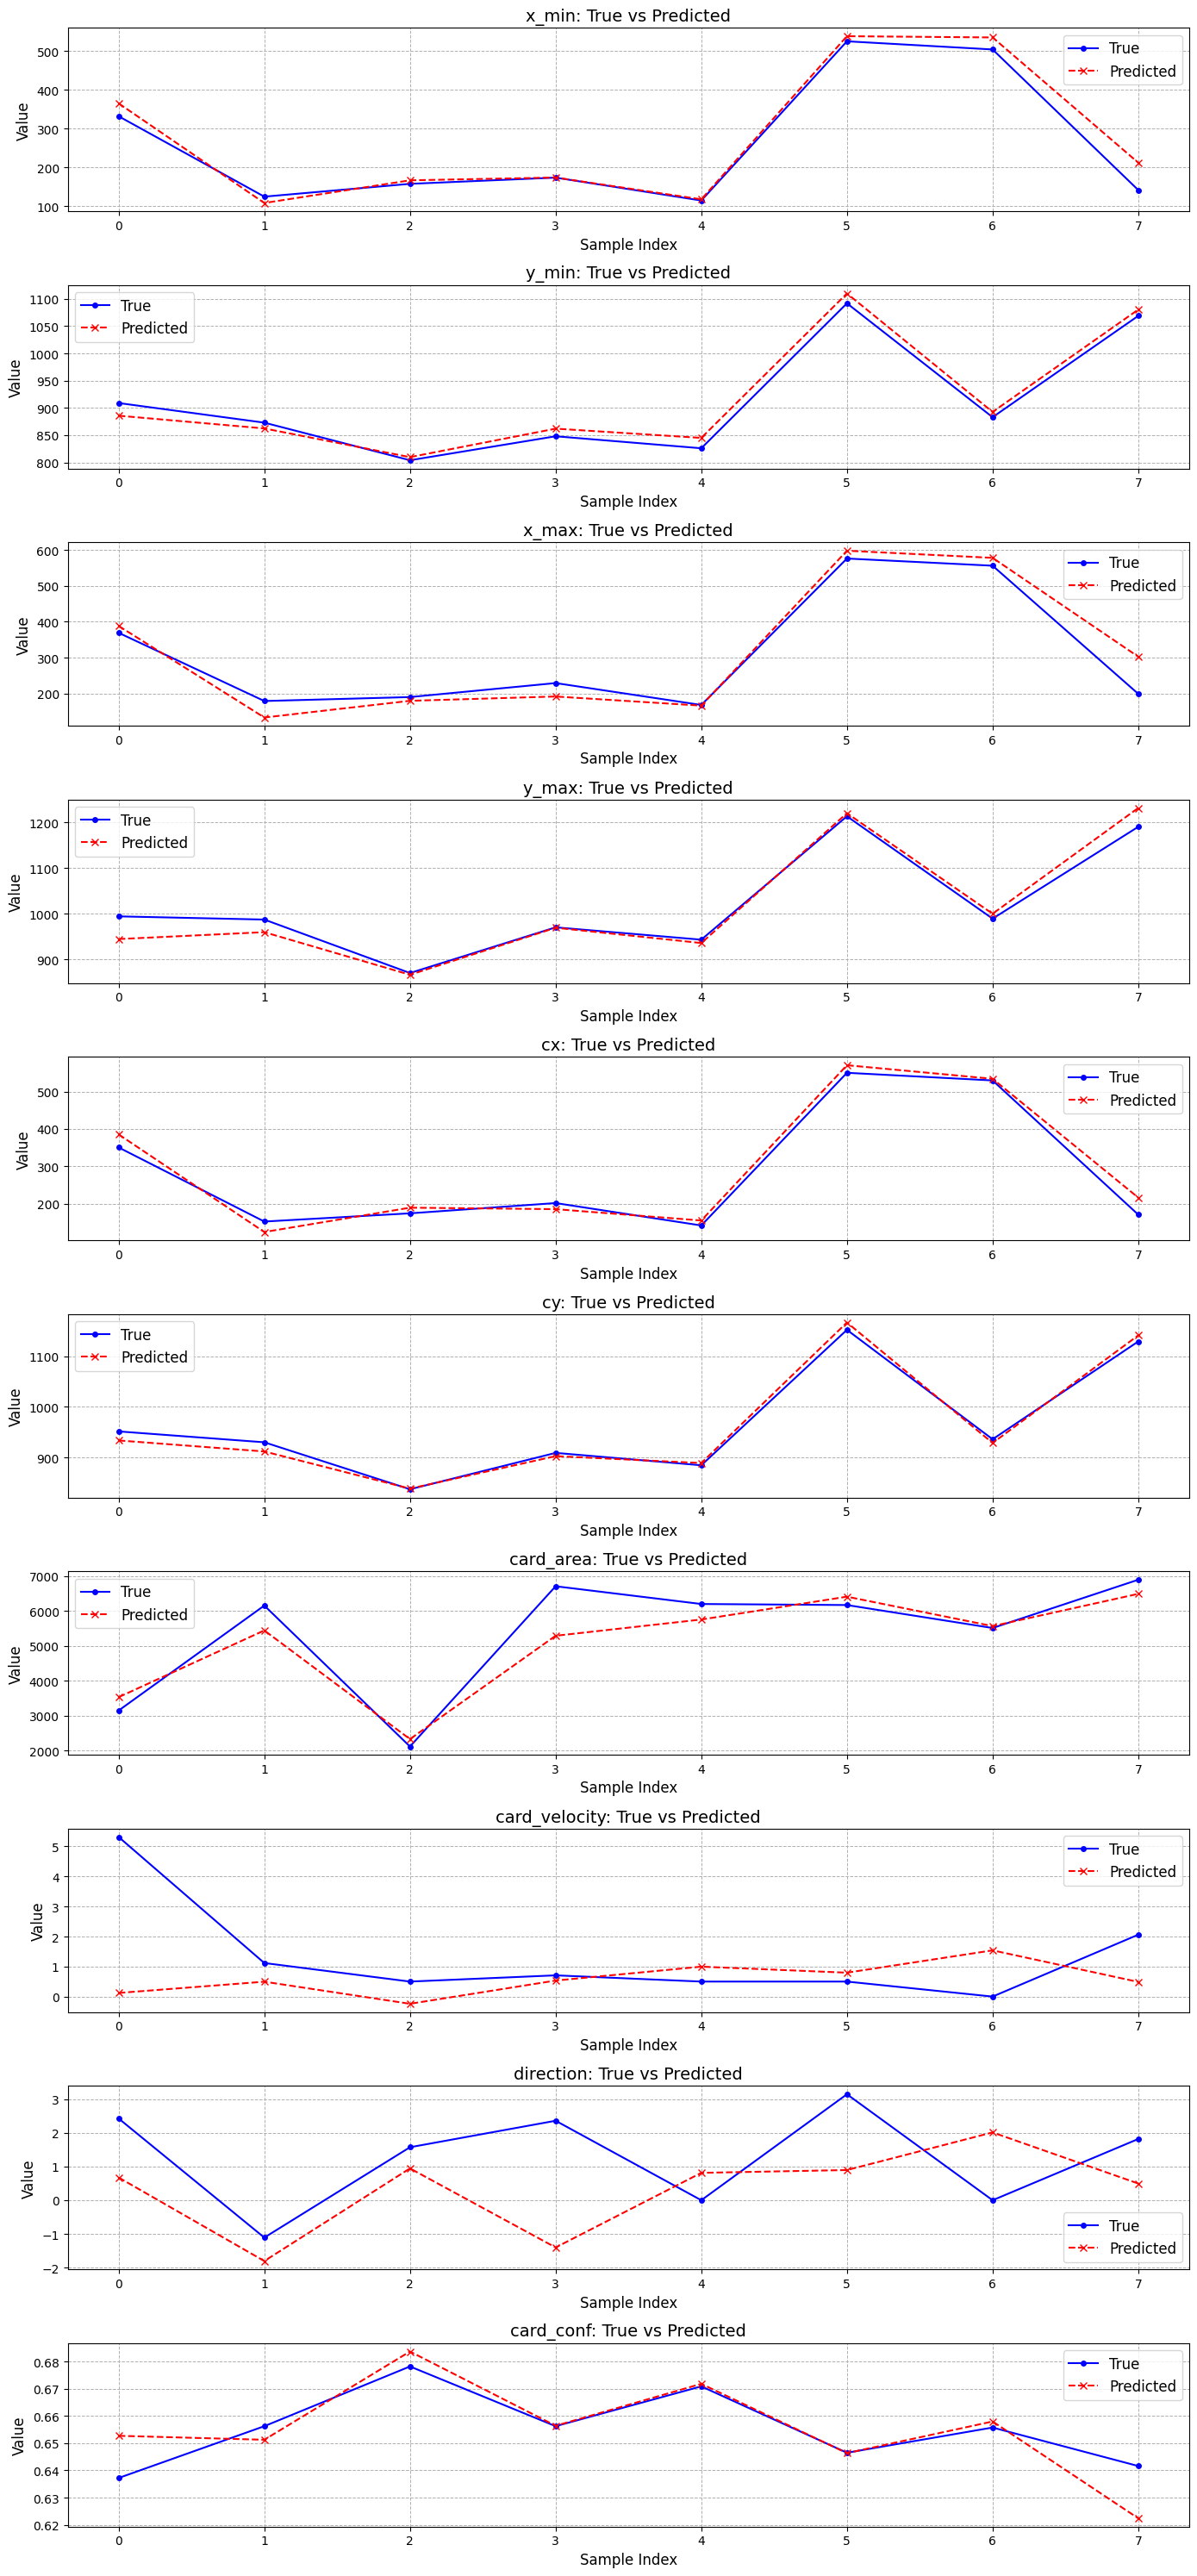

In [36]:
import matplotlib.pyplot as plt
import numpy as np

print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)

# 时间步（样本）索引
samples = np.arange(y_test.shape[0])

# 特征标签
features = ['x_min', 'y_min', 'x_max', 'y_max', 'cx', 'cy', 'card_area', 'card_velocity', 'direction', 'card_conf']

# 创建图形和子图
fig, axes = plt.subplots(len(features), 1, figsize=(14, 3 * len(features)), tight_layout=True)
axes = axes.flatten()

# 绘制每个特征的真实值和预测值
for i in range(len(features)):
    ax = axes[i]
    ax.plot(samples, y_test[:, i], marker='o', linestyle='-', label='True', color='blue', markersize=4, linewidth=1.5)
    ax.plot(samples, predictions[:, i], marker='x', linestyle='--', label='Predicted', color='red', markersize=6, linewidth=1.5)
    ax.set_title(f'{features[i]}: True vs Predicted', fontsize=14)
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.legend(fontsize=12)

plt.show()


## 5. 评估指标可视化

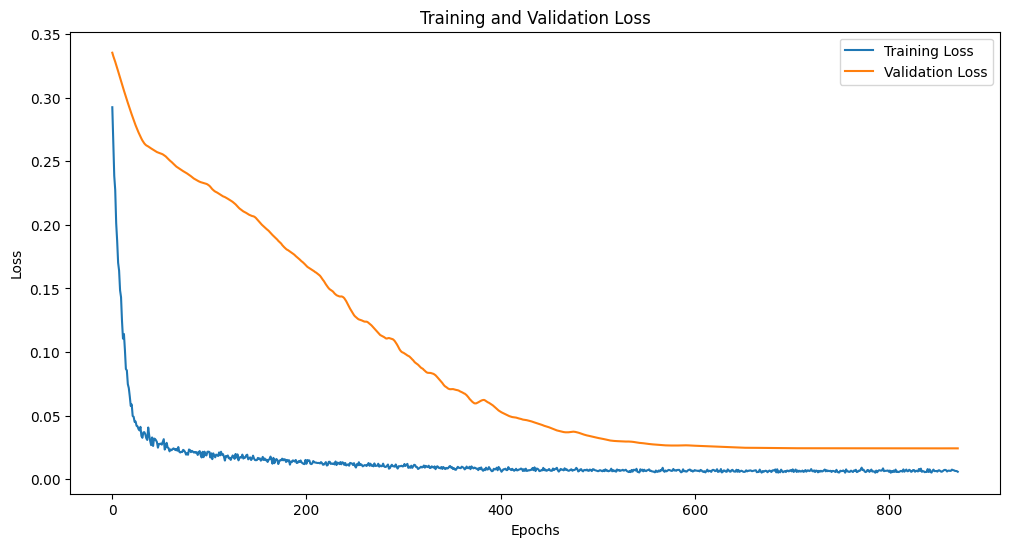

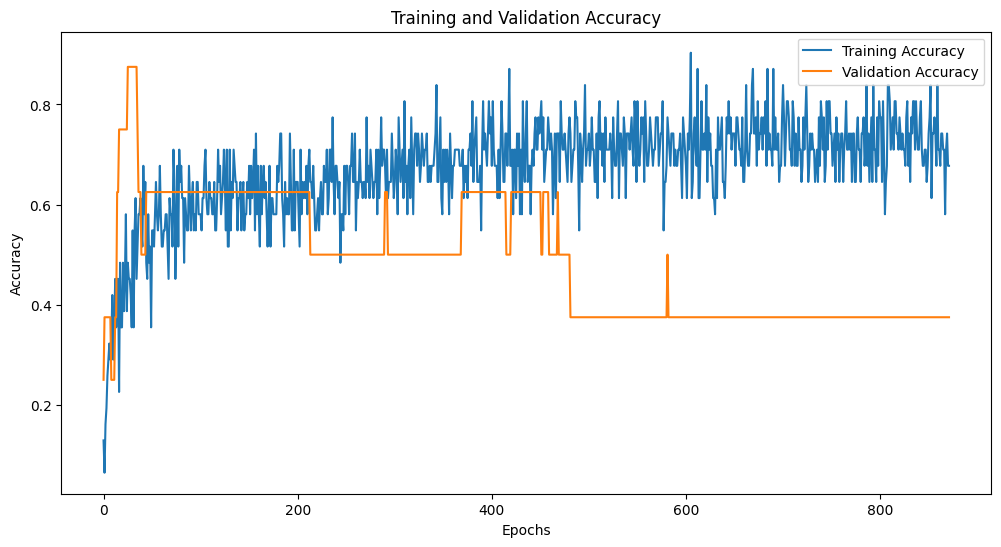

In [25]:
import matplotlib.pyplot as plt

# 绘制训练与验证损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练与验证准确度曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. 模型评估与测试

In [ ]:
# 假设有新的测试数据集
test_samples = 10  # 测试样本数
time_steps = 3
num_features = 10
test_data = np.random.rand(test_samples, time_steps, num_features)

# 对测试数据进行标准化：我们使用标准化来将数据缩放到均值为0，标准差为1的范围内
# (num_samples, time_steps, num_features) -> (num_samples * time_steps, num_features)
scaler = StandardScaler()
test_data_reshaped = test_data.reshape(-1, num_features)
test_data_reshaped = scaler.fit_transform(test_data_reshaped)

test_data_reshaped = scaler.transform(test_data_reshaped)
# (num_samples * time_steps, num_features) -> (num_samples, time_steps, num_features)
test_data = test_data_reshaped.reshape(test_samples, time_steps, num_features)

# 使用模型进行预测
predictions = lstm_model.predict(test_data)

# 将预测结果转换为类别标签
predicted_classes = np.argmax(predictions, axis=-1)

# 显示每个测试样本的预测结果
for i in range(test_samples):
    print(f"Sample {i+1} predictions: {predicted_classes[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 1 predictions: 9
Sample 2 predictions: 9
Sample 3 predictions: 9
Sample 4 predictions: 4
Sample 5 predictions: 9
Sample 6 predictions: 9
Sample 7 predictions: 9
Sample 8 predictions: 9
Sample 9 predictions: 1
Sample 10 predictions: 9


## 探索强化学习识别行为模式

In [ ]:
import random
from keras.models import Sequential
from keras.layers import Dense
from collections import deque
import numpy as np

# DQN（Deep Q-Network）
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # 折扣率
        self.epsilon = 1.0   # 探索率
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return  # 如果记忆库中的样本数量不足，直接返回
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * 
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 训练 DQN 模型以识别行为模式
state_size = 8  # 包括位置、速度、方向等
action_size = 3  # 假设有三种行为模式
agent = DQNAgent(state_size, action_size)

# 假设有环境交互部分 (类似 gym 环境)
for e in range(1000):
    state = np.random.rand(1, state_size)  # 随机生成当前状态
    action = agent.act(state)  # 选择行为
    reward = random.random()  # 通过奖励函数优化策略
    next_state = np.random.rand(1, state_size)  # 生成下一个状态
    done = e == 999  # 判断是否结束
    agent.remember(state, action, reward, next_state, done)  # 记录经验
    agent.replay(32)  # 使用随机样本进行经验回放以训练DQN模型

### 1. 多模态数据输入, 模拟传感器数据 1000个样本, 4个特征

sensor_data = np.random.rand(1000, 4)  # 例如温度、光强度等